In [ ]:
import sys
import os
import math

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision

import nvidia
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.plugin.pytorch import DALIGenericIterator as PyTorchIterator
from nvidia.dali.plugin.pytorch import LastBatchPolicy

sys.path.append(os.path.abspath('flownet2'))
sys.path.append(os.path.abspath('flownet2/utils'))
from models import FlowNet2, FlowNet2SD
import flow_utils

import torchvision.models as models
import pytorch_msssim 

import time

from bfutils import 

# allow maximum memory per GPU
torch.cuda.set_per_process_memory_fraction(1.0, 1)
torch.cuda.set_per_process_memory_fraction(1.0, 0)

%matplotlib inline

In [2]:
print('Using CUDA', torch.version.cuda)
print('dev0 -', torch.cuda.get_device_name(0))
print('dev1 -', torch.cuda.get_device_name(1))

Using CUDA 11.6
dev0 - NVIDIA GeForce GTX 1080
dev1 - NVIDIA GeForce GTX 1070


In [3]:
## Hyperparameters
batch_size = 1
workspace = '.'

# Video Loading Parameters

# command to convert obs recording to hevc for dali: 
# ffmpeg -i bf4_rawdata.avi -c:v libx265 -x265-params lossless=1 -vtag hvc1 -c:a copy -an output.mp4
sequence_length = 5                       # Number of frames per data sequence
initial_prefetch_size = 2                 # look at DALI docs. Probably number of samples to prefetch
original_video_size = (1920//3, 1080//3)        # The original size of the recording
hires_sf = 1                              # 1/Scalefactor applied to original resolution image. hires_img = (1920x1080) / hires_sf
lores_sf = 2                              # 1/Scalefactor applied to original resolution image. lores_img = (1920x1080) / lores_sf
frame_stride = 2                          # Space btwn sampling frames. stride=1 --> 60fps, stride=2 --> 30fps, stride=3 --> 20fps ...

print("Reference Video Size:", np.array(original_video_size)/hires_sf)
print("Low Resolution Video Size:", np.array(original_video_size)/lores_sf)
print("Upscaling by", lores_sf/hires_sf)

Reference Video Size: [640. 360.]
Low Resolution Video Size: [320. 180.]
Upscaling by 2.0


In [4]:
class DataFactory():
    def __init__(self, flow_model_type='FlowNet2-SD', depth_model_type='DPT_Hybrid'):
        #model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
        #model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
        #model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
        with torch.no_grad():
            self.datadev = 1
            self.traindev = 0

            self.pipe = None

            self.midas = torch.hub.load("intel-isl/MiDaS", depth_model_type)
            self.midas.to(device=self.datadev)
            midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
            if flow_model_type == "DPT_Large" or flow_model_type == "DPT_Hybrid":
                self.transform = midas_transforms.dpt_transform
            else:
                self.transform = midas_transforms.small_transform

            class args: pass
            args.rgb_max = 1. 

            if flow_model_type == 'FlowNet2':
                print("Using FlowNet2...")
                args.fp16 = False
                self.flownet = FlowNet2(args)
                self.flownet.load_state_dict(torch.load('./pretrained/FlowNet2_checkpoint.pth.tar')['state_dict'])
            elif flow_model_type == 'FlowNet2-SD':
                print("Using FlowNet2-SD...")
                args.fp16 = True
                self.flownet = FlowNet2SD(args)
                self.flownet.load_state_dict(torch.load('./pretrained/FlowNet2-SD_checkpoint.pth.tar')['state_dict'])
            else:
                print("invalid flownet")
                assert "Invalid flownet"


            self.flownet.to(device=self.datadev)
            self.flownet.eval()
            
    def depth(self, input_batch): 
        """ Computes Depth on a batch of images using MiDaS """
        with torch.no_grad():
            prediction = self.midas(input_batch)
        return prediction / torch.max(prediction)
    
    def flow(self, x):
        """ Computes Depth on a batch of images using FlowNet2 """
        with torch.no_grad():
            prediction = self.flownet(x)
        return prediction 
    
    def get_dali_iterator(self):
        """ 
        Creates a DALI pipeline for loading video data and doing 
        basic pre-processing on it. Returns a PyTorch friendly iterator
        """
        @pipeline_def
        def video_pipe(lores_sf, hires_sf, stride):
            out = fn.readers.video(
                device="gpu", 
                sequence_length=sequence_length, 
                random_shuffle=True, 
                file_list="filelist.txt",
                file_list_frame_num=True,
                enable_frame_num=True, 
                initial_fill=initial_prefetch_size,
                stride=stride,
                name="Reader")
            video = out[0]
            
            # Switch to (N, Frames, C, H, W)
            video = fn.transpose(video, perm=[0, 3, 1, 2]) 

            # Convert to 0-1 range
            video /= 255
            
            return out[2], video

        self.pipe = video_pipe(lores_sf, hires_sf, frame_stride, 
                          batch_size=batch_size, num_threads=1, device_id=self.datadev, seed=12345)
        self.pipe.build()
        pii = PyTorchIterator(self.pipe, ['frame', 'video'], 
                              reader_name="Reader", last_batch_policy=LastBatchPolicy.PARTIAL)
        
        return pii

    def get_epoch_size(self):
        return self.pipe.epoch_size()

    @torch.no_grad()
    def pre_compute_data_from_iter(self, data):
        """ 
        Computes Optic Flow and Depth for a batch of video sequences returned 
        from the DALI pipeline and its iterator. 
        """
        
        '''
        lores = fn.resize(video, resize_x=original_video_size[0]//lores_sf)

        if hires_sf != 1: 
            hires = fn.resize(video, resize_x=original_video_size[0]//hires_sf)
        else:
            hires = video

        # pre-transform depth for MiDas network
        depth = (hires - 0.5) * 2
        depth = fn.resize(depth, resize_y=192, resize_x=384, 
                          interp_type=nvidia.dali.types.DALIInterpType.INTERP_CUBIC)

        square = fn.resize(hires, 
                           resize_y=square_shape[1]//lores_sf, 
                           resize_x=square_shape[0]//lores_sf, 
                           interp_type=nvidia.dali.types.DALIInterpType.INTERP_CUBIC)

        return out[2], lores, hires, depth, square
        '''
        video = data[0]['video']
        start_frame = data[0]['frame']
        return start_frame, *self.prep_frameset(video)
    
    def prep_frameset(self, video):
        _batch_size = video.shape[0]
        with torch.no_grad():
            nearest_square_shape = (192, 320)

            square = nn.functional.interpolate(video.flatten(0, 1), size=nearest_square_shape)
            square = square.unflatten(0, (_batch_size, sequence_length))
            
            depth = nn.functional.interpolate(square.flatten(0, 1), size=(192, 384))
            depth = (depth - 0.5) * 2
            
            # compute depth over batch * frame dimension: (N, frames, 1, H, W)
            depth = self.depth(depth)
            depth = depth.unflatten(0, (_batch_size, sequence_length)).unsqueeze(2)
            depth = nn.functional.interpolate(depth, [1] + list(square.shape[3:]))

            # get RGBD for each frame
            rgbd = torch.cat((square, depth), axis=2)

            del square, depth

            #torch.cuda.empty_cache()
            #torch.cuda.synchronize()

            # pre-allocate the flow tensor (N, Frames-1, 2, H, W)
            flows = torch.empty(*([_batch_size, 4, 2] + list(rgbd.shape)[3:]), device=self.datadev)
            for i in range(_batch_size): 
                batch = rgbd[i, :, 0:3, ...]
                # pre-allocate the temporally continuous frames for this batch 
                inp = torch.empty(*([4, 3, 2] + list(batch.shape)[2:]), device=self.datadev)
                # concatenate adjacent frames for input into flownet 
                for p in range(4): 
                    pair = batch[p:p+2, ...]
                    inp[p, ...] = pair.transpose(1, 0)
                # execute flownet on the frame batch and add it to the main flow tensor
                flows[i, ...] = self.flow(inp)

            return video[:, 4, ...], rgbd, flows




In [5]:
class LossFactory():
    def __init__(self):
        self.features = list(models.vgg16(pretrained=True).features)[:23]
        self.features = torch.nn.ModuleList(self.features).cuda(0).eval()
        self.ssim_module = pytorch_msssim.SSIM(data_range=255, size_average=True, channel=3)

    def perceptual_loss(self, out, ref):
        layers = {15}
        layers = {3, 8, 15, 22}
        
        # make sure we have gradient on output for gradient of loss calculation
        if not out.requires_grad:
            out = torch.autograd.Variable(out, requires_grad=True)
            
        fout = self.get_perceptual_features(out, layers_to_pick_from=layers)
        fref = self.get_perceptual_features(ref, layers_to_pick_from=layers)
        loss = 0
        for i in range(len(fout)):
            loss += fout[i].dist(fref[i], p=2) / torch.numel(fref[i])
        return loss
    
    def get_perceptual_features(self, x, layers_to_pick_from={3,8,15,22}):
        results = []
        for ii,model in enumerate(self.features):
            if ii > max(layers_to_pick_from): break
            x = model(x)
            if ii in layers_to_pick_from:
                results.append(x)
        return results
    
    def ssim_loss(self, out, ref):
        
        if len(out.shape) != len(ref.shape): 
            assert "Out and ref must have same dim count"
            
        if len(out.shape) == 3: 
            if type(out) == torch.Tensor:
                out = out.unsqueeze(0)
                ref = ref.unsqueeze(0)
            elif type(out) == np.ndarray:
                out = np.expand_dims(out, 0)
                ref = np.expand_dims(ref, 0)
                
        # make sure we have gradient on output for gradient of loss calculation
        if not out.requires_grad:
            out = torch.autograd.Variable(out, requires_grad=True)
            
        return self.ssim_module(out, ref)
     
    def total_loss(self, out, ref): 
        return 1 - self.ssim_loss(out, ref) - 0.1 * self.perceptual_loss(out, ref)

In [6]:
class UpsampleZero(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, img, scale_factor):
        """
        IMPORTANT: we only support integer scaling factors for now!!
        """
        # input shape is: batch x channels x height x width
        # output shape is:
        device = img.device
        input_size = torch.tensor(img.size(), dtype=torch.int)
        input_image_size = input_size[2:] # input_image_size[0]-height, input_image_size[1]-width
        data_size = input_size[:2]
        
        # Get the last two dimensions -> height x width
        # compare to given scale factor
        b_ = np.asarray(scale_factor)
        b = torch.tensor(b_)
        # check that the dimensions of the tuples match.
        if len(input_image_size) != len(b):
            raise ValueError("scale_factor should match input size!")
        output_image_size = (input_image_size * b).type(torch.int) # element-wise product

        scale_factor = torch.tensor(np.asarray(scale_factor), dtype=torch.int)
        ##
        output_size = torch.cat((data_size, output_image_size))
        output = torch.zeros(tuple(output_size.tolist()))
        ##
        # todo: use output.view(...) instead.
        output[:, :, ::scale_factor[0], ::scale_factor[1]] = img
        return output.to(device=device)
    
class BackwardWarper(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x_image, x_motion):
        """ Stolen from github nsrr-reimplementation """

        index_batch, _, height, width = x_image.size()
        grid_x = torch.arange(width).view(1, -1).repeat(height, 1)
        grid_y = torch.arange(height).view(-1, 1).repeat(1, width)
        grid_x = grid_x.view(1, 1, height, width).repeat(index_batch, 1, 1, 1)
        grid_y = grid_y.view(1, 1, height, width).repeat(index_batch, 1, 1, 1)
        ##  
        grid = torch.cat((grid_x, grid_y), 1).float().to(device=x_motion.device)
        # grid is: [batch, channel (2), height, width]
        vgrid = grid + x_motion
        # Grid values must be normalised positions in [-1, 1]
        vgrid_x = vgrid[:, 0, :, :]
        vgrid_y = vgrid[:, 1, :, :]
        vgrid[:, 0, :, :] = (vgrid_x / width) * 2.0 - 1.0
        vgrid[:, 1, :, :] = (vgrid_y / height) * 2.0 - 1.0

        # swapping grid dimensions in order to match the input of grid_sample.
        # that is: [batch, output_height, output_width, grid_pos (2)]
        vgrid = vgrid.permute((0, 2, 3, 1)).to(device=x_image.device)
        output = torch.nn.functional.grid_sample(x_image, vgrid, mode='nearest', align_corners=False)
        return output

class FeatureExtractionNet(nn.Module):
    def __init__(self, kernel_size=3, padding='same'):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=kernel_size, padding=padding),
            nn.ReLU()
        )
        
    def forward(self, rgbd_tensor):
        # rgbd_tensor: (N, C, H, W) where C = R, G, B, D channels
        full_features = self.net(rgbd_tensor)
        channel_dim = len(rgbd_tensor.shape)-1-2
        return torch.concat((rgbd_tensor, full_features), dim=channel_dim)

class FeatureReweightingNet(nn.Module):
    '''Adopted from nsrr github'''
    def __init__(self, kernel_size=3, padding='same', scale=10):
        super().__init__()

        self.scale = scale
        self.net = nn.Sequential(
            # We think of the input as the concatanation of RGB-Ds of current frame, which has 4 channles
            # and full features of previous frames, each of which has 12 channels
            # so `in_channels=20`, which is 4+4*12 = 52
            # To save memory, we have to feed the upsampled RGB-D to compute a weight and calculate the weighted sum of the 12 channels
            nn.Conv2d(in_channels=4*5, out_channels=32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=4, kernel_size=kernel_size, padding=padding),
            nn.Tanh()
        )
        
    def forward(self, current_rgbd_scaled, previous_features):
        stacked_reweighted_rgbds = torch.cat([
            current_rgbd_scaled.unsqueeze(1)[:, :, 0:4, ...], 
            previous_features[:, :, 0:4, ...] 
        ], dim=1)
        stacked_reweighted_rgbds = stacked_reweighted_rgbds.flatten(1, 2)
        
        w = self.net(stacked_reweighted_rgbds)
        w = (w-(-1))/2*self.scale # Scale
        
        weighted_previous_features = [w[:,i,:,:].unsqueeze(1)*previous_features[:, i, ...] for i in range(4)] # Reweighting
        return weighted_previous_features

class ReconstructionNet(nn.Module):
    '''Adopted from NSRR github repo'''
    def __init__(self, kernel_size=3, padding='same'):
        super().__init__()
        self.pooling = nn.MaxPool2d(2)

        # Split the network into 5 groups of 2 layers to apply concat operation at each stage
        # todo: the first layer of the model would take
        # the concatenated features of all previous frames,
        # so the input number of channels of the first 2D convolution
        # would be 12 * self.number_previous_frames
        self.encoder_1 = nn.Sequential(
            nn.Conv2d(12*4+12, 64, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=kernel_size, padding=padding),
            nn.ReLU()
        )
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=kernel_size, padding=padding),
            nn.ReLU()
        )
        self.center = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),

        )
        self.decoder_1 = nn.Sequential(
            nn.Conv2d(128+64, 64, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        self.decoder_2 = nn.Sequential(
            nn.Conv2d(32+64, 32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, current_features, reweighted_previous_features):
        # Features of the current frame and the reweighted features
        # of previous frames are concatenated
        
        reconstruction_inp = torch.cat([
            current_features.unsqueeze(1), 
            reweighted_previous_features
        ], dim=1)
        reconstruction_inp = reconstruction_inp.flatten(1, 2)

        channel_dim = 1
   
        out_encoder_1 = self.pooling(self.encoder_1(reconstruction_inp))
        
        out_encoder_2 = self.pooling(self.encoder_2(out_encoder_1))
        
        out_center = self.center(out_encoder_2)
        
        out_decoder_1 = self.decoder_1(torch.concat((out_center, out_encoder_2), dim=channel_dim))

        out_decoder_2 = self.decoder_2(torch.concat((out_encoder_1, out_decoder_1), dim=channel_dim))

        return out_decoder_2

In [7]:
class NSRR(nn.Module):
    def __init__(self, fnet):
        super().__init__()
        self.past_fextractor = fnet #FeatureExtractionNet()
        self.current_fextractor = FeatureExtractionNet()
        self.upsample_zero = UpsampleZero()
        self.upsample_factor = 2 
        self.backward_warp = BackwardWarper()
        self.reweighter = FeatureReweightingNet()
        self.reconstructer = ReconstructionNet()
        
        self.past_fextractor.cuda()
        self.reweighter.cuda()
    
    def forward(self, rgbds, flows): 
        _batch_size = rgbds.shape[0]
        
        current_rgbd = rgbds[:, -1, ...]
        current_features = self.current_fextractor(current_rgbd)
        current_features = self.upsample_zero(current_features,  [self.upsample_factor]*2)
        
        input_shape = torch.tensor(current_rgbd.shape[-2:])
        
        past_rgbds = rgbds[:, 0:-1, ...]
        past_features = torch.empty([_batch_size, 4, 12] + (input_shape*self.upsample_factor).tolist())
        for i in range(4): 
            past = past_rgbds[:, i, ...]
            past_feature = self.past_fextractor(past)
            past_feature = self.upsample_zero(past_feature, [self.upsample_factor]*2)
            past_features[:, i, ...] = past_feature
        
        # past_features[0] -> frame i-4
        # past_features[1] -> frame i-3
        # past_features[2] -> frame i-2
        # past_features[3] -> frame i-1
        # current_features -> frame i 
        
        flows = torch.nn.functional.interpolate(flows.flatten(0, 1), 
                                                scale_factor=self.upsample_factor, 
                                                mode='bilinear')
        flows = flows.unflatten(0, (_batch_size, 4))
        
        
        # Do Accumulative backward warping in batches
        # Frame i-1 gets warped into frame i using flow(i-1 --> i)
        # Frame i-2 gets warped into frame i using flow(i-2 --> i-1) and then flow(i-1 --> i)
        # Frame i-3 gets warped into frame i using flow(i-3 --> i-2), flow(i-2 --> i-1), flow(i-1 --> i)
        # Frame i-4 gets warped into frame i using flow(i-4 --> i-3), ..., flow(i-1 --> i)
        done_warped = [None] * 4
        warped = past_features
        for i in range(4):
            to_warp = warped[:, 0:4-i, ...].flatten(0, 1)
            warp_flows = flows[:, i:4, ...].flatten(0, 1)
            warped = self.backward_warp(to_warp, warp_flows)
            warped = warped.unflatten(0, (_batch_size, 4-i))
            done_warped[3-i] = warped[:, 3-i, ...]
            
        # done_warped[0] --> zero upscaled, acc. warped frame_minus_4
        # done_warped[1] --> zero upscaled, acc. warped frame_minus_3
        # done_warped[2] --> zero upscaled, acc. warped frame_minus_2
        # done_warped[3] --> zero upscaled, warped frame_minus_1
        
        # Create input to Feature Reweighting network
        done_warped = torch.stack(done_warped, dim=1).cuda()
        current_rgbd_scaled = current_features[:, 0:4, ...]
        
        reweighted = self.reweighter(current_rgbd_scaled, done_warped)
        reweighted = torch.stack(reweighted, dim=1).cuda() 
        
        reconstructed = self.reconstructer(current_features, reweighted)
        
        return reconstructed 
        
        

In [8]:
dataf = DataFactory(flow_model_type='FlowNet2')
dataf_iter = dataf.get_dali_iterator()

Using cache found in /home/tjz/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/tjz/.cache/torch/hub/intel-isl_MiDaS_master


Using FlowNet2...


In [2]:
class args: pass
args.fp16 = False
args.rgb_max = 1.0
flownet = FlowNet2(args)
flownet.load_state_dict(torch.load('./pretrained/FlowNet2_checkpoint.pth.tar')['state_dict'])
flownet.cuda(1)
flownet.eval()
pass

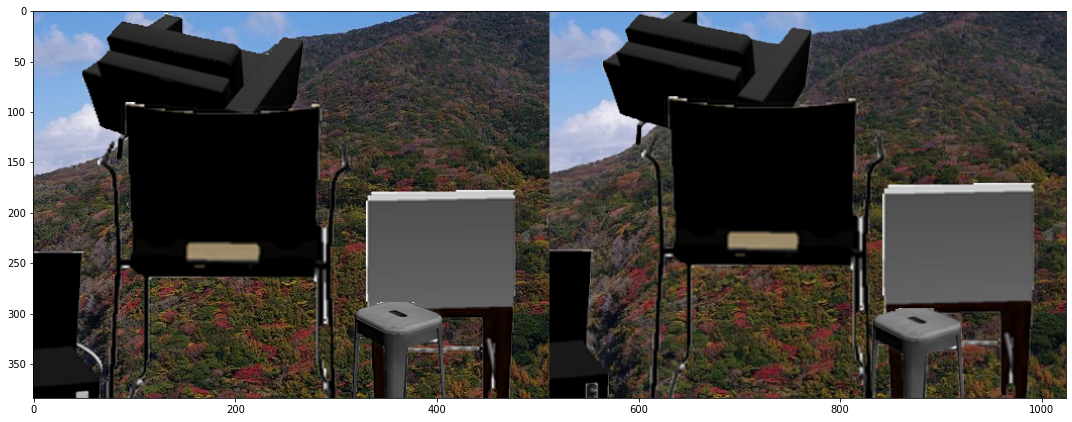

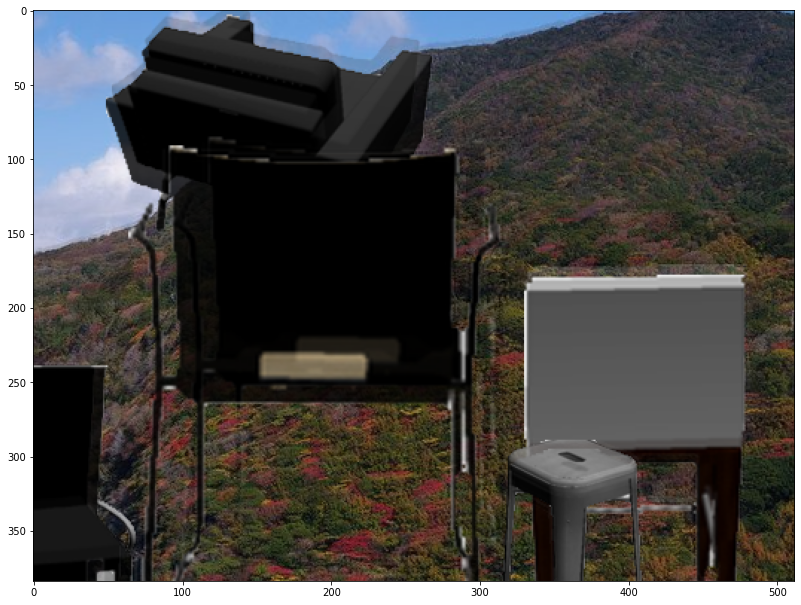

flonwet input: torch.Size([1, 3, 2, 384, 512])


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [3]:


_im1 = plt.imread('test/img0.ppm')
_im2 = plt.imread('test/img1.ppm')

def viz_diff(_im1, _im2):
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(np.hstack([_im1, _im2]))
    plt.show()
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(cv2.addWeighted(_im1,0.8,_im2,0.2,0))
    plt.show()
    data, out = run_optic_flow(flownet, _im1/255, _im2/255, dev=1)
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(out)
    plt.show()
    return data, out

viz_diff(_im1, _im2)
pass

In [9]:
traindev = 0
fext = FeatureExtractionNet()
nsrr = NSRR(fext)
nsrr.cuda(traindev)

NSRR(
  (past_fextractor): FeatureExtractionNet(
    (net): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU()
      (4): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (5): ReLU()
    )
  )
  (current_fextractor): FeatureExtractionNet(
    (net): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU()
      (4): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (5): ReLU()
    )
  )
  (upsample_zero): UpsampleZero()
  (backward_warp): BackwardWarper()
  (reweighter): FeatureReweightingNet(
    (net): Sequential(
      (0): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1),

In [10]:
criterion = LossMaker()    
optimizer = torch.optim.Adam(nsrr.parameters(), lr=0.0001)

In [11]:
train_start_t = None
def train(model):
    global train_start_t
    train_start_t = time.time()
    print('started training at', train_start_t)
    print('epoch_size=', dataf.get_epoch_size())
    epochs = 80
    hires = None
    rgbd = None
    flows = None
    last_t = time.time()
    for e in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataf_iter):
            start_frame, _hires, _rgbd, _flows = dataf.pre_compute_data_from_iter(data)
            
            hires  = _hires.to(device=traindev)
            rgbd   = _rgbd.to(device=traindev)
            flows  = _flows.to(device=traindev)
            
            # at this point, we have a batch of: 
            # --------------
            # hires  = reference high resolution goal
            # rgbd   = low resolution RGB-Depth tensor for 5 frames
            # flows  = 4 frames of optica flow calculated as delta between the 5 frames
            # start_frame = frame when this sequence begins in the original data
            
            optimizer.zero_grad()
            outputs = model(rgbd, flows)
            
            #print('reshaping outputs from,', outputs.shape, 'to', hires.shape)
            outputs = torch.nn.functional.interpolate(outputs, size=hires.shape[-2:], mode='nearest')
            loss = criterion.total_loss(outputs, hires)
            loss.backward()
            optimizer.step()
            
            print("epoch: {}, loss={}, frame={} iter {}, real batch size: {}".format(e, loss, start_frame, i, 0))
            #del _hires, _rgbd, _flows
            #del start_frame, hires, rgbd, flows
            #torch.cuda.empty_cache()
        dataf_iter.reset()
    #return hires, rgbd, flows
out = train(nsrr)
if out is not None:
    hires, rgbd, flows = out

started training at 1650311988.282873
epoch_size= {'Reader': 600}


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
# started at 2:12
cap = cv2.VideoCapture('./videos/bf4_lossless_640x360.mp4')
succ, img = cap.read()
frames = []
i = 0
while succ and i < 140:
    frames.append(cv2.resize(img, original_video_size))
    succ, img = cap.read()
    i += 1

In [ ]:
def run_test_np(model, frameset):
    ref = torch.tensor(np.array(frameset)).transpose(-1, 1).transpose(-1, 2).unsqueeze(0).cuda(1)
    ref, rgbd, flow = dataf.prep_frameset(ref)
    with torch.no_grad():
        x = model(rgbd.cuda(0), flow.cuda(0))
    print(ref.shape)
    print(x.shape)
    print(rgbd.shape)
    print(flow.shape)
    x, ref = x.cpu().detach().numpy(), ref.cpu().detach().numpy()
    x, ref = x.squeeze(0), ref.squeeze(0)
    x = np.transpose(x, (1, 2, 0))
    
    if False:
        x = np.clip(x, 0, 1)
    else:
        x = (x - np.min(x)) / np.max(x)
        
    print(np.min(x))
    ref = np.transpose(ref, (1, 2, 0))
    return x, ref
    
x, ref = run_test_np(nsrr, frames[60:70:2])
imshow(x) 
imshow(ref)

In [ ]:
print('hey')